In [2]:
import os
import os.path as path
import gc
import re
import math
import json

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
pd.set_option('display.max_row', 50)
pd.set_option('display.max_columns', 100)

In [8]:
# 디렉토리 기본 경로 설정
DIR_PATH = path.join('..')
DIR_SAVE_PATH = path.join('.')

print(DIR_PATH)
print(DIR_SAVE_PATH)

..
.


In [9]:
# bean_raw_data.csv
user_read = pd.read_csv(path.join(DIR_PATH, 'user_propensity_data.csv'), low_memory=False)

print(user_read.shape)
user_read.columns = ['timestamp', 'phone', 'cafe', 'preference', 'drink', 'dessert', 'fruit', 'aroma']
user_read.head()

(105, 8)


,timestamp,phone,cafe,preference,drink,dessert,fruit,aroma
0,2023. 3. 24 오후 2:59:41,010-9491-7668,스타벅스 Starbucks,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"체리, 복숭아",허브의 마음이 진정되는 향기
1,2023. 3. 24 오후 3:03:33,010-2840-2336,스타벅스 Starbucks,다른 커피를 마실때보다 목넘김이 좋아요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",진하고 달달한 초코 케이크,"사과, 배",꿀이나 설탕같은 달달한 향기
2,2023. 3. 24 오후 3:03:50,010-9231-9670,투썸플레이스 A TWOSOME PLACE,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"크랜베리, 블루베리",허브의 마음이 진정되는 향기
3,2023. 3. 24 오후 3:04:09,010-9027-0157,이디야 커피 EDIYA COFFEE,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",나무의 우디한 향기
4,2023. 3. 24 오후 3:04:13,010-4404-9238,스타벅스 Starbucks,설탕이나 초콜릿 냄새라던가 맛이 선명해요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",상큼하고 개운한 과일 타르트,"사과, 배",꽃의 신선한 향기


In [10]:
user_data = user_read.iloc[:, 2:].copy()
user_data.head()

,cafe,preference,drink,dessert,fruit,aroma
0,스타벅스 Starbucks,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"체리, 복숭아",허브의 마음이 진정되는 향기
1,스타벅스 Starbucks,다른 커피를 마실때보다 목넘김이 좋아요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",진하고 달달한 초코 케이크,"사과, 배",꿀이나 설탕같은 달달한 향기
2,투썸플레이스 A TWOSOME PLACE,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"크랜베리, 블루베리",허브의 마음이 진정되는 향기
3,이디야 커피 EDIYA COFFEE,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",나무의 우디한 향기
4,스타벅스 Starbucks,설탕이나 초콜릿 냄새라던가 맛이 선명해요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",상큼하고 개운한 과일 타르트,"사과, 배",꽃의 신선한 향기


In [11]:
user_data.loc[(user_data['cafe'] != '스타벅스 Starbucks') \
& (user_data['cafe'] != '투썸플레이스 A TWOSOME PLACE') \
& (user_data['cafe'] != '이디야 커피 EDIYA COFFEE') \
& (user_data['cafe'] != '카페 파스쿠치 CAFFÉ PASCUCCI'), 'cafe'] = "_기타"
user_data

,cafe,preference,drink,dessert,fruit,aroma
0,스타벅스 Starbucks,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"체리, 복숭아",허브의 마음이 진정되는 향기
1,스타벅스 Starbucks,다른 커피를 마실때보다 목넘김이 좋아요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",진하고 달달한 초코 케이크,"사과, 배",꿀이나 설탕같은 달달한 향기
2,투썸플레이스 A TWOSOME PLACE,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"크랜베리, 블루베리",허브의 마음이 진정되는 향기
3,이디야 커피 EDIYA COFFEE,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",나무의 우디한 향기
4,스타벅스 Starbucks,설탕이나 초콜릿 냄새라던가 맛이 선명해요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",상큼하고 개운한 과일 타르트,"사과, 배",꽃의 신선한 향기
...,...,...,...,...,...,...
100,_기타,커피의 새콤한 맛이 도드라져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",꽃의 신선한 향기
101,이디야 커피 EDIYA COFFEE,커피 특유의 씁쓸한 맛이 잘 나타나요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"레몬, 오렌지, 귤",나무의 우디한 향기
102,카페 파스쿠치 CAFFÉ PASCUCCI,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"크랜베리, 블루베리",나무의 우디한 향기
103,투썸플레이스 A TWOSOME PLACE,커피의 새콤한 맛이 도드라져요,"☕에스프레소 또는 아메리카노, 콜드브루",담백하고 고소한이 두드러지는 호두파이,"망고, 바나나, 파인애플",허브의 마음이 진정되는 향기


In [12]:
cafe_list = np.sort(user_data['cafe'].unique()).tolist()
print(cafe_list)

if 'cafe_label' in user_data:
    user_data.drop(labels=['cafe_label'], axis=1, inplace=True)

# user_data.insert(int(user_data.columns.get_indexer(['cafe'])[0] + 1), 'cafe_label', user_data['cafe'].map(lambda x: cafe_list.index(x)), )
user_data.insert(len(user_data.columns), 'cafe_label', user_data['cafe'].map(lambda x: cafe_list.index(x)))

['_기타', '스타벅스 Starbucks', '이디야 커피 EDIYA COFFEE', '카페 파스쿠치 CAFFÉ PASCUCCI', '투썸플레이스 A TWOSOME PLACE']


In [13]:
preference_list = np.sort(user_data['preference'].unique()).tolist()
print(preference_list)

if 'preference_label' in user_data:
    user_data.drop(labels=['preference_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'preference_label', user_data['preference'].map(lambda x: preference_list.index(x)))

['다른 커피를 마실때보다 목넘김이 좋아요', '설탕이나 초콜릿 냄새라던가 맛이 선명해요', '커피 특유의 씁쓸한 맛이 잘 나타나요', '커피의 새콤한 맛이 도드라져요', '향이나 맛이 다른 커피보다 잘 느껴져요']


In [14]:
drink_list = np.sort(user_data['drink'].unique()).tolist()
print(drink_list)

if 'drink_label' in user_data:
    user_data.drop(labels=['drink_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'drink_label', user_data['drink'].map(lambda x: drink_list.index(x)))

['☕에스프레소 또는 아메리카노, 콜드브루', '🌸티 또는 주스', '🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)', '🥛카페라떼 또는 카푸치노, 마끼아또 (달지않아요)']


In [15]:
dessert_list = np.sort(user_data['dessert'].unique()).tolist()
print(dessert_list)

if 'dessert_label' in user_data:
    user_data.drop(labels=['dessert_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'dessert_label', user_data['dessert'].map(lambda x: dessert_list.index(x)))

['담백하고 고소한이 두드러지는 호두파이', '상큼하고 개운한 과일 타르트', '진하고 달달한 초코 케이크']


In [16]:
fruit_list = np.sort(user_data['fruit'].unique()).tolist()
print(fruit_list)

if 'fruit_label' in user_data:
    user_data.drop(labels=['fruit_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'fruit_label', user_data['fruit'].map(lambda x: fruit_list.index(x)))

['레몬, 오렌지, 귤', '망고, 바나나, 파인애플', '사과, 배', '체리, 복숭아', '크랜베리, 블루베리']


In [17]:
aroma_list = np.sort(user_data['aroma'].unique()).tolist()
print(aroma_list)

if 'aroma_label' in user_data:
    user_data.drop(labels=['aroma_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'aroma_label', user_data['aroma'].map(lambda x: aroma_list.index(x)))

['감귤의 상큼한 향기', '꽃의 신선한 향기', '꿀이나 설탕같은 달달한 향기', '나무의 우디한 향기', '허브의 마음이 진정되는 향기']


In [18]:
user_data.head()

,cafe,preference,drink,dessert,fruit,aroma,cafe_label,preference_label,drink_label,dessert_label,fruit_label,aroma_label
0,스타벅스 Starbucks,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"체리, 복숭아",허브의 마음이 진정되는 향기,1,4,0,2,3,4
1,스타벅스 Starbucks,다른 커피를 마실때보다 목넘김이 좋아요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",진하고 달달한 초코 케이크,"사과, 배",꿀이나 설탕같은 달달한 향기,1,0,2,2,2,2
2,투썸플레이스 A TWOSOME PLACE,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"크랜베리, 블루베리",허브의 마음이 진정되는 향기,4,4,0,1,4,4
3,이디야 커피 EDIYA COFFEE,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",나무의 우디한 향기,2,0,0,2,0,3
4,스타벅스 Starbucks,설탕이나 초콜릿 냄새라던가 맛이 선명해요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",상큼하고 개운한 과일 타르트,"사과, 배",꽃의 신선한 향기,1,1,2,1,2,1


In [19]:
user_label = user_data.iloc[:, 6:].copy()
user_label.head()

,cafe_label,preference_label,drink_label,dessert_label,fruit_label,aroma_label
0,1,4,0,2,3,4
1,1,0,2,2,2,2
2,4,4,0,1,4,4
3,2,0,0,2,0,3
4,1,1,2,1,2,1


In [20]:
survey_transform = np.array(
 # '_기타', '스타벅스', '이디야 커피', '카페 파스쿠치', '투썸플레이스'
[[[6, 6, 6, 6, 6, 6], [8, 4, 4, 9, 6, 6], [4, 8, 5, 6, 8, 4], [7, 10, 8, 6, 7, 6], [9, 5, 3, 7, 10, 7]], 
 # '바디', '단맛', '쓴맛', '산미', '향미'
 [[0, 0, 0, 0, 12, 6], [0, 0, 12, 0, 0, 6], [0, 0, 0, 12, 0, 6], [0, 12, 0, 0, 0, 6], [12, 0, 0, 0, 0, 6]], 
 # '블랙', '티/주스', '단 음료', '우유 첨가 음료'
 [[12, 7, 4, 10, 9, 6], [11, 5, 11, 1, 4, 4], [8, 2, 12, 2, 6, 5], [7, 3, 7, 4, 11, 8], [0, 0, 0, 0, 0, 0]], 
 # '호두파이', '과일 타르트', '초코 케이크'
 [[7, 0, 4, 7, 10, 5], [9, 5, 8, 2, 4, 7], [5, 1, 10, 4, 9, 4], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 
 # '레몬, 오렌지, 귤', '망고, 바나나, 파인애플', '사과, 배', '체리, 복숭아', '크랜베리, 블루베리'
 [[8, 12, 4, 6, 5, 6], [7, 5, 9, 4, 10, 5], [6, 6, 7, 2, 3, 10], [12, 3, 10, 3, 2, 5], [5, 8, 6, 9, 4, 4]], 
 # '시트러스', '플로럴', '슈가/허니', '우디', '허브'
 [[8, 10, 4, 1, 5, 3], [10, 3, 3, 3, 4, 8], [9, 0, 10, 0, 6, 5], [5, 1, 1, 9, 10, 4], [11, 2, 2, 3, 5, 6]]])
survey_transform

array([[[ 6,  6,  6,  6,  6,  6],
        [ 8,  4,  4,  9,  6,  6],
        [ 4,  8,  5,  6,  8,  4],
        [ 7, 10,  8,  6,  7,  6],
        [ 9,  5,  3,  7, 10,  7]],

       [[ 0,  0,  0,  0, 12,  6],
        [ 0,  0, 12,  0,  0,  6],
        [ 0,  0,  0, 12,  0,  6],
        [ 0, 12,  0,  0,  0,  6],
        [12,  0,  0,  0,  0,  6]],

       [[12,  7,  4, 10,  9,  6],
        [11,  5, 11,  1,  4,  4],
        [ 8,  2, 12,  2,  6,  5],
        [ 7,  3,  7,  4, 11,  8],
        [ 0,  0,  0,  0,  0,  0]],

       [[ 7,  0,  4,  7, 10,  5],
        [ 9,  5,  8,  2,  4,  7],
        [ 5,  1, 10,  4,  9,  4],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]],

       [[ 8, 12,  4,  6,  5,  6],
        [ 7,  5,  9,  4, 10,  5],
        [ 6,  6,  7,  2,  3, 10],
        [12,  3, 10,  3,  2,  5],
        [ 5,  8,  6,  9,  4,  4]],

       [[ 8, 10,  4,  1,  5,  3],
        [10,  3,  3,  3,  4,  8],
        [ 9,  0, 10,  0,  6,  5],
        [ 5,  1,  1,  9, 10,  4],
    

In [21]:
survey_transform[0][1]

array([8, 4, 4, 9, 6, 6])

In [22]:
list(enumerate([x for x in user_label.iloc[0, :]]))

[(0, 1), (1, 4), (2, 0), (3, 2), (4, 3), (5, 4)]

In [23]:
def label_transform(idx, matrix, transform):
    tf_sum = np.array([0,0,0,0,0,0])
    for i, j in list(enumerate([x for x in matrix.iloc[idx, :]])):
        tf_sum += transform[i][j]
        # print(transform[i][j])

    tf_mean = tf_sum / (6*6*2)
    # print(tf_mean)
    return tf_mean

In [24]:
user_label.apply(lambda x: label_transform(x.name, user_label, survey_transform), axis=1)

0      [0.8333333333333334, 0.2361111111111111, 0.416...
1      [0.5, 0.18055555555555555, 0.5972222222222222,...
2      [0.8055555555555556, 0.375, 0.3194444444444444...
3      [0.4722222222222222, 0.4027777777777778, 0.333...
4      [0.5694444444444444, 0.2777777777777778, 0.638...
                             ...                        
100    [0.5694444444444444, 0.5694444444444444, 0.375...
101    [0.5277777777777778, 0.4583333333333333, 0.305...
102    [0.4722222222222222, 0.375, 0.4027777777777778...
103    [0.6388888888888888, 0.4305555555555556, 0.305...
104    [0.7361111111111112, 0.2916666666666667, 0.375...
Length: 105, dtype: object

In [25]:
user_label_tf_df = pd.DataFrame(columns=['flavor', 'acidity', 'sweetness', 'bitterness', 'body', 'balance'])
user_label_tf = user_label.apply(lambda x: label_transform(x.name, user_label, survey_transform), axis=1)
user_label_tf_df = user_label_tf.apply(lambda x: pd.Series(x, index=['flavor', 'acidity', 'sweetness', 'bitterness', 'body', 'balance']))

In [26]:
user_label_tf_df.head()

,flavor,acidity,sweetness,bitterness,body,balance
0,0.833333,0.236111,0.416667,0.402778,0.430556,0.458333
1,0.500000,0.180556,0.597222,0.236111,0.583333,0.500000
2,0.805556,0.375000,0.319444,0.430556,0.444444,0.500000
3,0.472222,0.402778,0.333333,0.486111,0.736111,0.416667
4,0.569444,0.277778,0.638889,0.250000,0.319444,0.583333


In [27]:
user_label_tf_df = user_label_tf_df.iloc[:, :-1]
user_label_tf_df.head()

,flavor,acidity,sweetness,bitterness,body
0,0.833333,0.236111,0.416667,0.402778,0.430556
1,0.500000,0.180556,0.597222,0.236111,0.583333
2,0.805556,0.375000,0.319444,0.430556,0.444444
3,0.472222,0.402778,0.333333,0.486111,0.736111
4,0.569444,0.277778,0.638889,0.250000,0.319444


In [29]:
user_label_tf_df.max(axis=1)

0      0.833333
1      0.597222
2      0.805556
3      0.736111
4      0.638889
         ...   
100    0.569444
101    0.625000
102    0.708333
103    0.638889
104    0.736111
Length: 105, dtype: float64

In [34]:
user_label_tf_df.iloc[1].idxmax()

'sweetness'

In [44]:
user_label_tf_df.iloc[:, :5]

,flavor,acidity,sweetness,bitterness,body
0,0.833333,0.236111,0.416667,0.402778,0.430556
1,0.500000,0.180556,0.597222,0.236111,0.583333
2,0.805556,0.375000,0.319444,0.430556,0.444444
3,0.472222,0.402778,0.333333,0.486111,0.736111
4,0.569444,0.277778,0.638889,0.250000,0.319444
...,...,...,...,...,...
100,0.569444,0.569444,0.375000,0.402778,0.458333
101,0.527778,0.458333,0.305556,0.625000,0.500000
102,0.472222,0.375000,0.402778,0.527778,0.708333
103,0.638889,0.430556,0.305556,0.430556,0.611111


In [113]:
user_label_tf_df['1st_param'] = user_label_tf_df.iloc[:, :5].apply(lambda x : x.idxmax(), axis=1)
user_label_tf_df['2nd_param'] = user_label_tf_df.iloc[:, :6].apply(lambda x : x.drop([x['1st_param'], '1st_param']).astype('float').idxmax(), axis=1)
user_label_tf_df['survey_type'] = user_label_tf_df.iloc[:, 5:7].apply(lambda x : 'category '+''.join(map(str, user_label_tf_df.columns.get_indexer(x.values))), axis=1)
user_label_tf_df.head()

,flavor,acidity,sweetness,bitterness,body,1st_param,2nd_param,survey_type
0,0.833333,0.236111,0.416667,0.402778,0.430556,flavor,body,category 04
1,0.500000,0.180556,0.597222,0.236111,0.583333,sweetness,body,category 24
2,0.805556,0.375000,0.319444,0.430556,0.444444,flavor,body,category 04
3,0.472222,0.402778,0.333333,0.486111,0.736111,body,bitterness,category 43
4,0.569444,0.277778,0.638889,0.250000,0.319444,sweetness,flavor,category 20


In [121]:
print(user_label_tf_df['1st_param'].value_counts())
print(user_label_tf_df['2nd_param'].value_counts())
print(user_label_tf_df[['1st_param', '2nd_param']].value_counts(sort=False))
print(user_label_tf_df['survey_type'].value_counts())

flavor        61
body          17
sweetness     16
bitterness     9
acidity        2
Name: 1st_param, dtype: int64
flavor        36
body          35
sweetness     15
bitterness    13
acidity        6
Name: 2nd_param, dtype: int64
1st_param   2nd_param 
acidity     flavor         2
bitterness  body           2
            flavor         6
            sweetness      1
body        bitterness     2
            flavor        15
flavor      acidity        6
            bitterness    11
            body          30
            sweetness     14
sweetness   body           3
            flavor        13
dtype: int64
category 04    30
category 40    15
category 02    14
category 20    13
category 03    11
category 30     6
category 01     6
category 24     3
category 43     2
category 34     2
category 10     2
category 32     1
Name: survey_type, dtype: int64


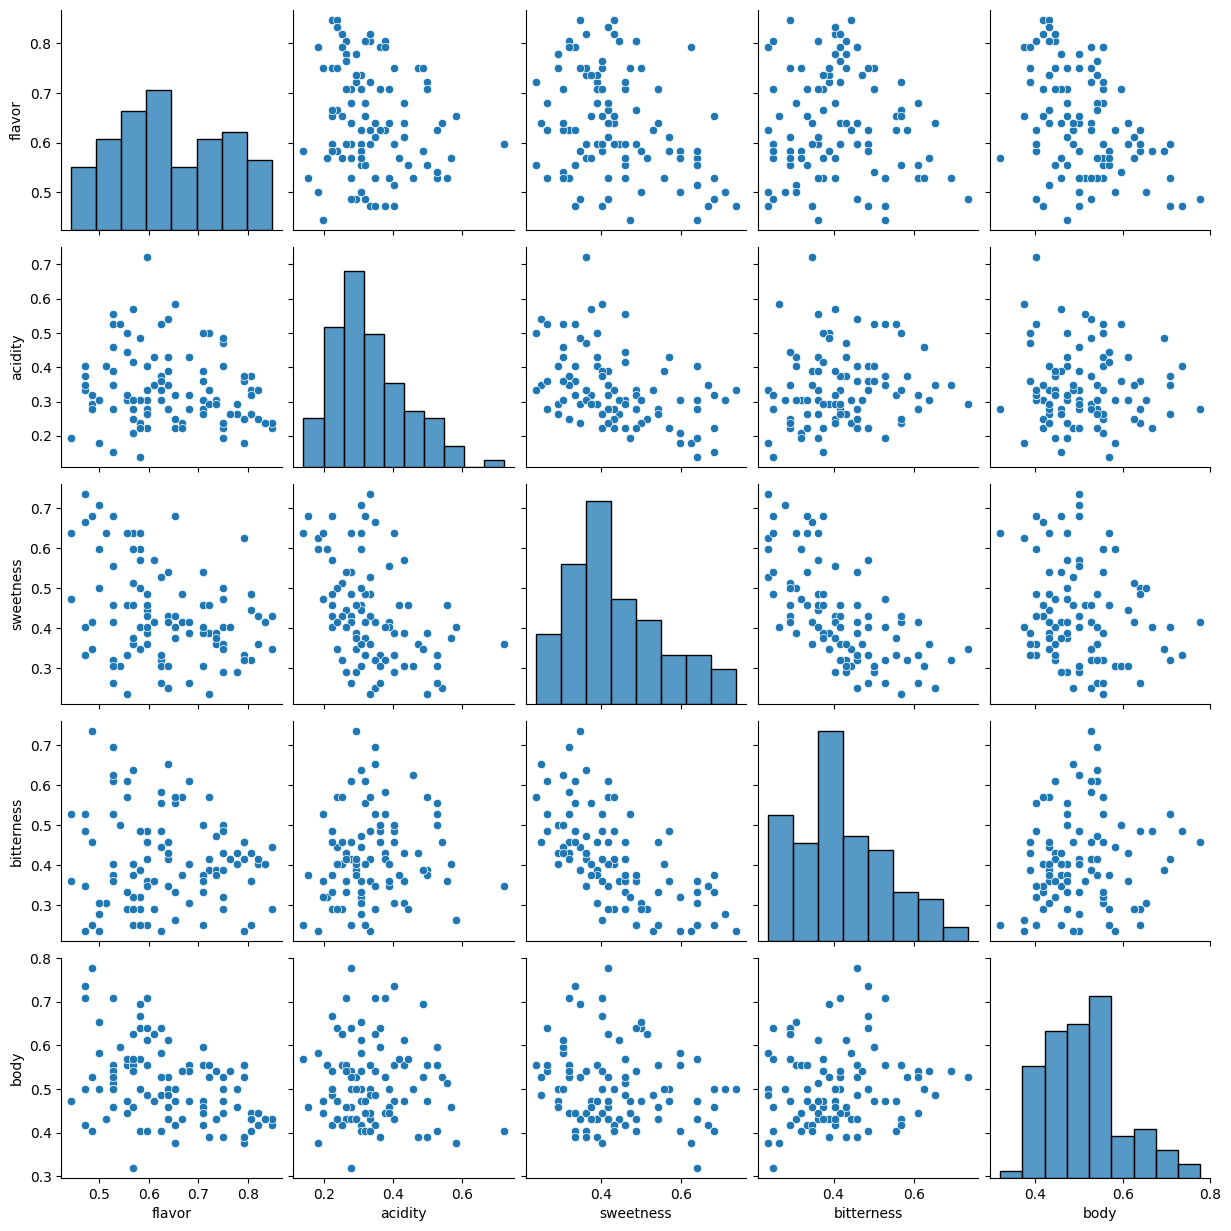

In [27]:
sns.pairplot(user_label_tf_df)

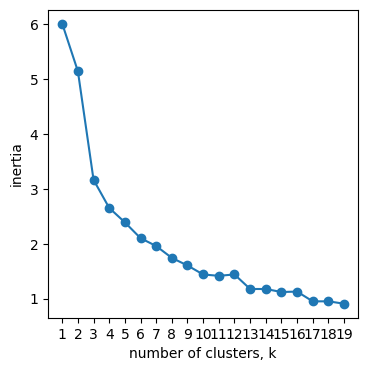

In [28]:
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(1,20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(user_label_tf_df)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [29]:
# K-Means 모델과 군집 예측값을 생성

# 클러스터 모델 생성 파라미터는 원할 경우 추가
clust_model = KMeans(n_clusters = 6, n_init='auto'
#                      , max_iter=500 # KMeans를 몇번 반복 수행할건지, K가 큰 경우 1000정도로 높여준다
#                      , random_state = 42
#                      , algorithm='auto'
                    )

# 생성한 모델로 데이터를 학습시킴
clust_model.fit(user_label_tf_df) # unsupervised learning 

# 결과 값을 변수에 저장
centers = clust_model.cluster_centers_ # 각 군집의 중심점
pred = clust_model.predict(user_label_tf_df) # 각 예측군집

print(pd.DataFrame(centers))
print(pred[:10])

          0         1         2         3         4
0  0.747685  0.360532  0.359375  0.405093  0.468171
1  0.624074  0.256481  0.443519  0.463889  0.518519
2  0.557292  0.460938  0.366319  0.427083  0.600694
3  0.546086  0.278409  0.608586  0.302399  0.506944
4  0.601852  0.360185  0.311111  0.600000  0.524074
5  0.782051  0.255342  0.480769  0.325855  0.436966
[5 3 0 2 3 4 5 5 1 4]


In [30]:
# 원래 데이터에 예측된 군집 붙이기
user_label_tf_clust_df = user_label_tf_df.copy()
user_label_tf_clust_df['clust'] = pred
user_label_tf_clust_df.head()

,flavor,acidity,sweetness,bitterness,body,clust
0,0.833333,0.236111,0.416667,0.402778,0.430556,5
1,0.500000,0.180556,0.597222,0.236111,0.583333,3
2,0.805556,0.375000,0.319444,0.430556,0.444444,0
3,0.472222,0.402778,0.333333,0.486111,0.736111,2
4,0.569444,0.277778,0.638889,0.250000,0.319444,3


In [31]:
for center, color in zip(centers, [x for x in mcolors.TABLEAU_COLORS]):
    print(str(center) + ' ' + color)

[0.74768519 0.36053241 0.359375   0.40509259 0.4681713 ] tab:blue
[0.62407407 0.25648148 0.44351852 0.46388889 0.51851852] tab:orange
[0.55729167 0.4609375  0.36631944 0.42708333 0.60069444] tab:green
[0.54608586 0.27840909 0.60858586 0.30239899 0.50694444] tab:red
[0.60185185 0.36018519 0.31111111 0.6        0.52407407] tab:purple
[0.78205128 0.25534188 0.48076923 0.3258547  0.43696581] tab:brown


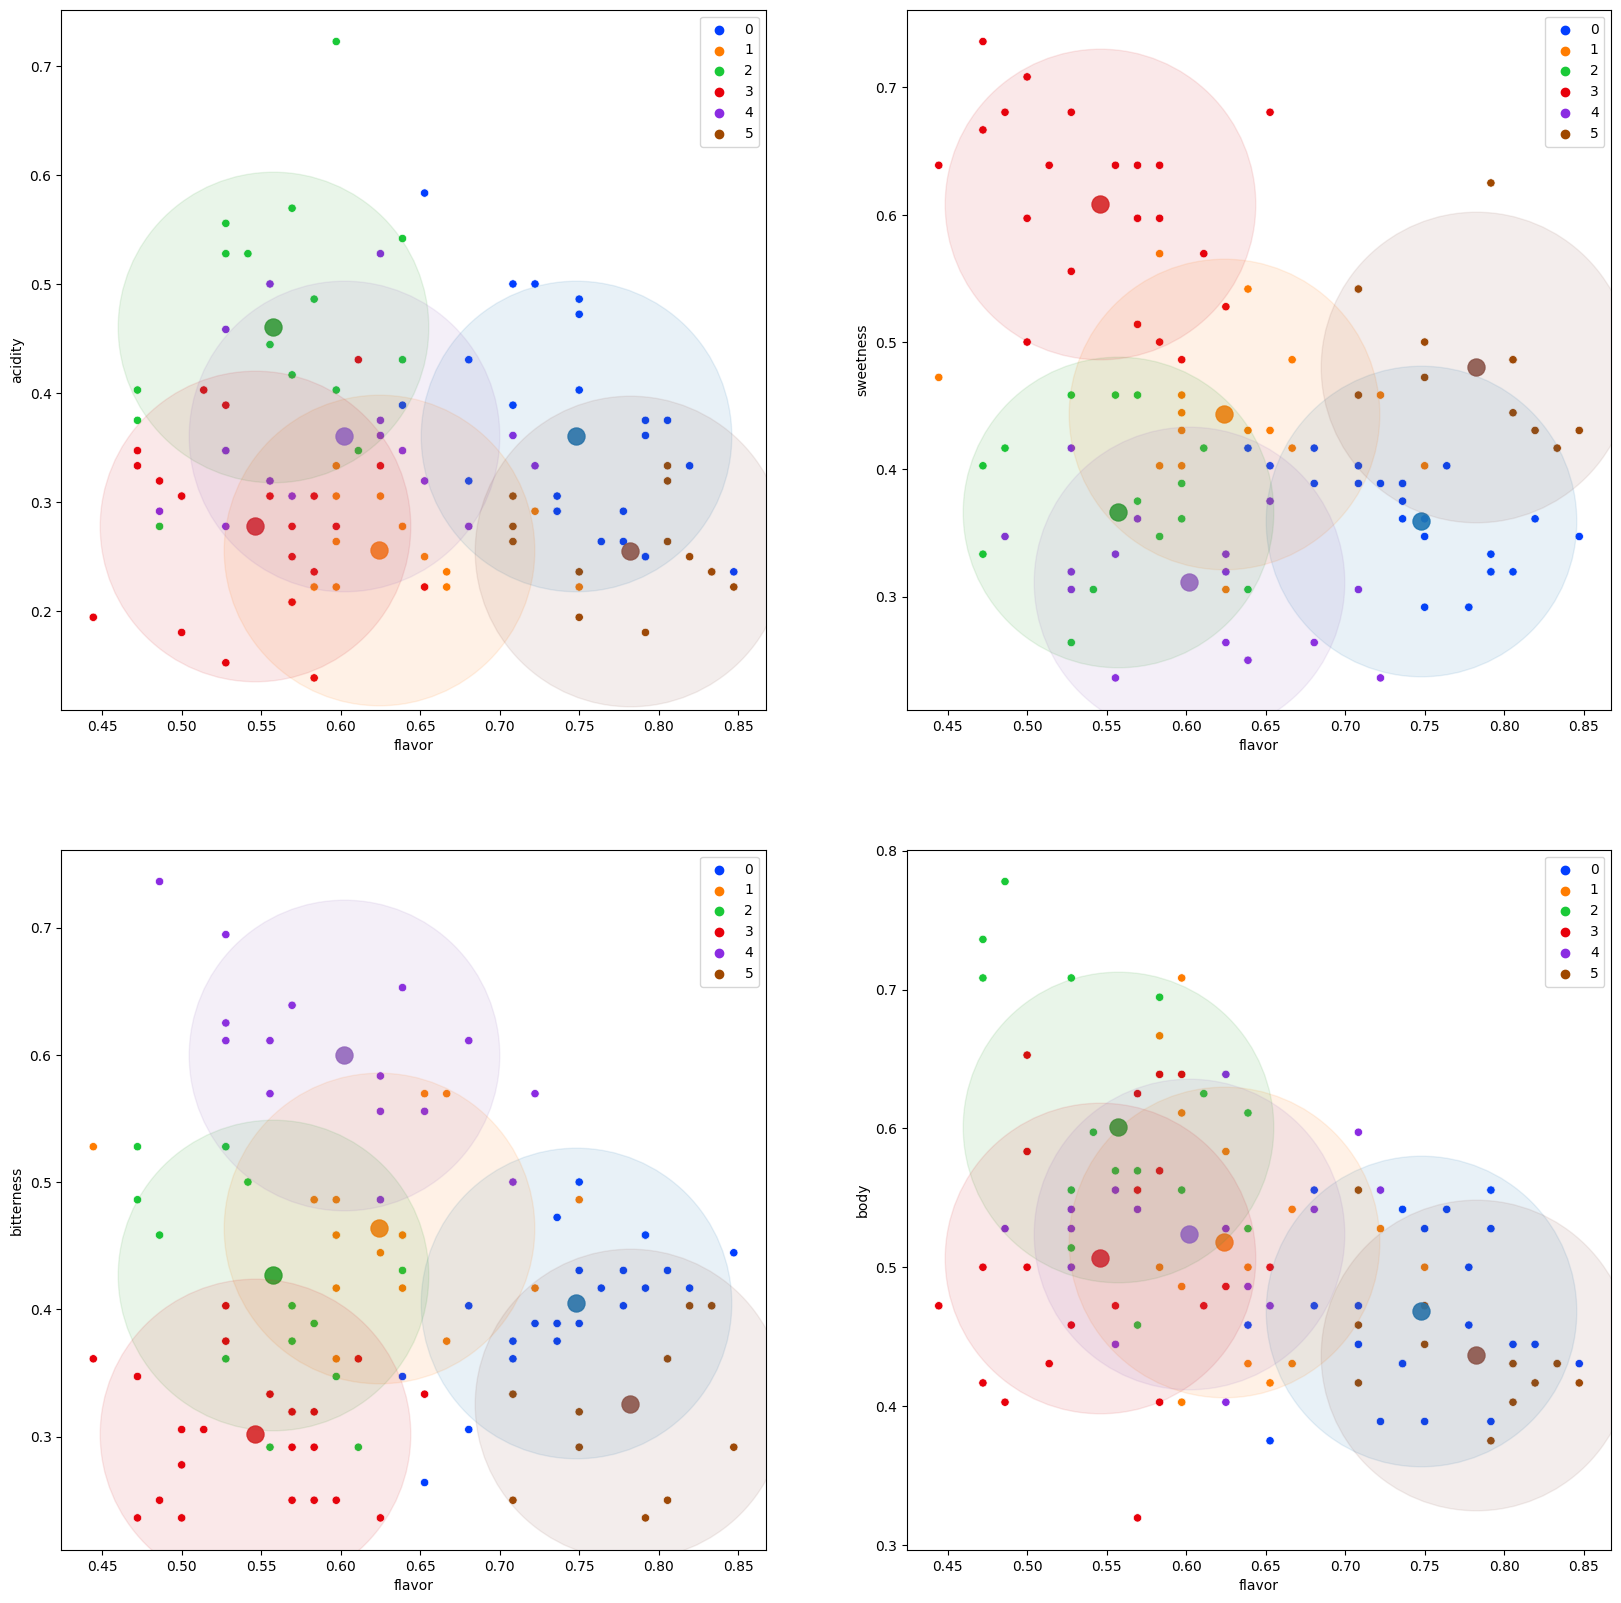

In [32]:
# scaling하지 않은 데이터를 학습하고 시각화하기
figs = 20
plt.figure(figsize=(figs, figs))

X = user_label_tf_clust_df

plt.subplot(221)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=user_label_tf_df, hue=clust_model.labels_, palette='bright')
for center, color in zip(centers, [x for x in mcolors.TABLEAU_COLORS]):
    plt.scatter(center[0], center[1], c=color, alpha=0.9, s=150)
    plt.scatter(center[0], center[1], c=color, alpha=0.1, s=figs*2500)

plt.subplot(222)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,2], data=user_label_tf_df, hue=clust_model.labels_, palette='bright')
for center, color in zip(centers, [x for x in mcolors.TABLEAU_COLORS]):
    plt.scatter(center[0], center[2], c=color, alpha=0.9, s=150)
    plt.scatter(center[0], center[2], c=color, alpha=0.1, s=figs*2500)

plt.subplot(223)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,3], data=user_label_tf_df, hue=clust_model.labels_, palette='bright')
for center, color in zip(centers, [x for x in mcolors.TABLEAU_COLORS]):
    plt.scatter(center[0], center[3], c=color, alpha=0.9, s=150)
    plt.scatter(center[0], center[3], c=color, alpha=0.1, s=figs*2500)

plt.subplot(224)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,4], data=user_label_tf_df, hue=clust_model.labels_, palette='bright')
for center, color in zip(centers, [x for x in mcolors.TABLEAU_COLORS]):
    plt.scatter(center[0], center[4], c=color, alpha=0.9, s=150)
    plt.scatter(center[0], center[4], c=color, alpha=0.1, s=figs*2500)

plt.show()

In [33]:
cluster_mean = user_label_tf_clust_df.groupby('clust').mean()
cluster_mean

,flavor,acidity,sweetness,bitterness,body
clust,,,,,
0,0.747685,0.360532,0.359375,0.405093,0.468171
1,0.624074,0.256481,0.443519,0.463889,0.518519
2,0.557292,0.460938,0.366319,0.427083,0.600694
3,0.546086,0.278409,0.608586,0.302399,0.506944
4,0.601852,0.360185,0.311111,0.600000,0.524074
5,0.782051,0.255342,0.480769,0.325855,0.436966


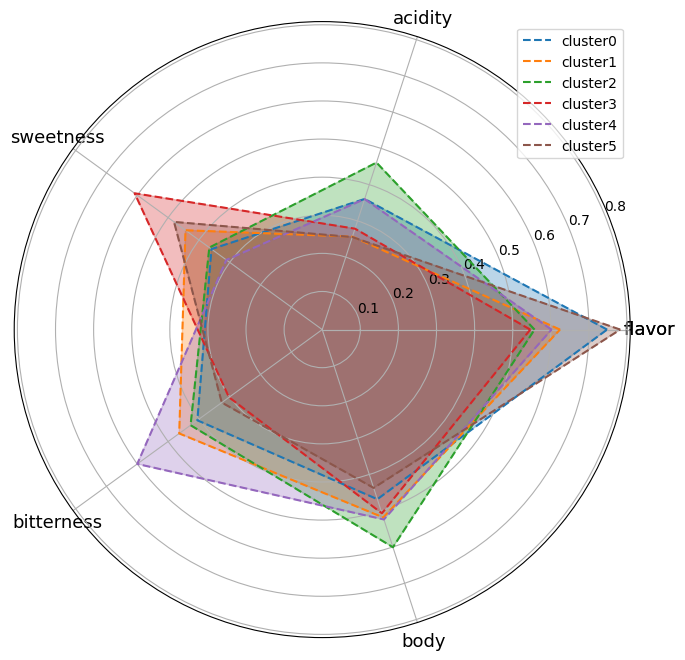

In [34]:
# radar로 cluster_k_mean 출력

categories = cluster_mean.columns[:]
categories = [*categories, categories[0]]

cluster = cluster_mean.apply(lambda x : [*list(x)[:], list(x)[0]], axis=1)

label_loc = np.linspace(start=0, stop=2*np.pi, num=len(cluster[0]))

plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)
plt.xticks(label_loc, labels=categories, fontsize=13)
plt.color_sequences
ax.plot(label_loc, cluster[0], label='cluster0', linestyle='dashed', color='tab:blue')
ax.fill(label_loc, cluster[0], color='tab:blue', alpha=0.3)
ax.plot(label_loc, cluster[1], label='cluster1', linestyle='dashed', color='tab:orange')
ax.fill(label_loc, cluster[1], color='tab:orange', alpha=0.3)
ax.plot(label_loc, cluster[2], label='cluster2', linestyle='dashed', color='tab:green')
ax.fill(label_loc, cluster[2], color='tab:green', alpha=0.3)
ax.plot(label_loc, cluster[3], label='cluster3', linestyle='dashed', color='tab:red')
ax.fill(label_loc, cluster[3], color='tab:red', alpha=0.3)
ax.plot(label_loc, cluster[4], label='cluster4', linestyle='dashed', color='tab:purple')
ax.fill(label_loc, cluster[4], color='tab:purple', alpha=0.3)
ax.plot(label_loc, cluster[5], label='cluster5', linestyle='dashed', color='tab:brown')
ax.fill(label_loc, cluster[5], color='tab:brown', alpha=0.3)
ax.legend()
plt.show()